Importing Packages And Basic Set up

In [35]:
#.venv/scripts/activate  ; no source. 
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, log_loss

import numpy as np
import pandas as pd

Importing Datasets

In [36]:
# Importing maindata
file_path = "C://Users/miste/Documents/Causal_ML/"
x = pd.read_stata(file_path + "maindata.dta", convert_categoricals=False)

# Importing laws_csv, cleaning it
laws_csv = pd.read_csv(file_path + "When_Were_Laws.csv")
laws_csv = laws_csv[np.logical_not(np.isnan(laws_csv["FIPS"]))]  # FIPS codes identify states
laws_csv = laws_csv.drop("State_Name", axis=1)  # Dropping as useless
laws_csv = laws_csv.rename({'FIPS': 'stfips'}, axis=1) 

# Merging
merged = pd.merge(laws_csv, x, on='stfips', how='outer')

Cleaning Datasets, only interested in the 1997 states. 

In [37]:
basic_merged = merged.copy()  # To allow for re-running 

basic_merged = basic_merged[basic_merged["a_age"] <= 25]  # Can be changed later, but for now useful I think

# Dropping states who were treated < 97 (i.e. they always had programs)
# This is following Callaway + Sant'anna, as we cannot meaningfully 
# do any inference using those states. Although we can compare them later as a 
# robustness check, which may be interesting
basic_merged = basic_merged[basic_merged["Year_Implemented"].str.contains("always")==False]  

# Making it so that "never-treated" states are treated at T = infinity
basic_merged = basic_merged.replace("never", "1000000") 
basic_merged["Year_Implemented"] = basic_merged["Year_Implemented"].astype(int)  # converting to int


# indicator for if treatment has occured in state i
basic_merged["year_indic"] = (basic_merged["year"] >= basic_merged["Year_Implemented"]) 


# Indicator for if the individual was treated (i.e. under 19 and in a state who added a law)
basic_merged["treatment"] = basic_merged["under19"] # * basic_merged["year_indic"]


# Generating list of confounders of interest, these are not necessarily optimal. 
list_of_confounders = ["year", "stfips", "fownu18", "faminctm1", "a_maritl", "female" , "fpovcut", "povll"]
list_of_confounders += ["anykids", "disability", "noemp_insured"]

In [50]:
test = np.empty(shape=(2,3))
print(test)
test[:,2] = np.array([2,2])
print(test[:,2])

[[0. 0. 0.]
 [1. 1. 0.]]
[2. 2.]


$\underline{\bold{\text{Estimating causal effect}}}$

Subsetting data

Fitting Model

In [38]:
def outcome_k_fold_fit_and_predict(make_model, X:pd.DataFrame, y:np.array, A:np.array, n_splits:int, output_type:str, y1:int, y0:int):
    '''
    Implements K fold cross-fitting for the model predicting the outcome Y. 
    That is, 
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each data point in fold j
    Returns two arrays containing the predictions for all units untreated, all units treated  

    Args:
    model: function that returns sklearn model (that implements fit and either predict_prob or predict)
    X: dataframe of variables to adjust for
    y: array of outcomes
    A: array of treatments
    n_splits: number of splits to use
    output_type: type of outcome, "binary" or "continuous"
    '''
    # Setting up prediction vectors
    predictions0_y1 = np.full_like(y, np.nan, dtype=float)
    predictions1_y1 = np.full_like(y, np.nan, dtype=float)
    predictions0_y0 = np.full_like(y, np.nan, dtype=float)
    predictions1_y0 = np.full_like(y, np.nan, dtype=float)
    predictions_matrix = np.empty(shape=(y.shape[0], 34))

    # k-folding
    if output_type == 'binary':
        kf = StratifiedKFold(n_splits=n_splits, shuffle=True)

    # include the treatment as input feature
    X_w_treatment = X.copy()
    X_w_treatment["A"] = A

    year_vec = np.full_like(X_w_treatment["year"], np.nan, dtype=float)
    treat_vec = np.full_like(X_w_treatment["year"], np.nan, dtype=float)
    for train_index, test_index in kf.split(X_w_treatment, y):
        X_train = X_w_treatment.loc[train_index]
        y_train = y.loc[train_index]
        q = make_model()
        q.fit(X_train, y_train)

        # This saves the vector of years so we only get the att for the 1997 group
        year_vec[test_index] =  X_w_treatment["year"].loc[test_index]

        # This saves the vector of treated statuses, as we want to condition on A = 1
        treat_vec[test_index] = A.loc[test_index]
        if output_type =='binary':
            for j in range(17):
                # for predicting effect under treatment / control status for each data point
                X0 = X_w_treatment.copy()
                X0["A"] = 0
                X0["year"] = j + 1992
                predictions_matrix[test_index,2*j] = q.predict_proba(X0.loc[test_index])[:, 1]
            for j in range(17):
                X1 = X_w_treatment.copy()
                X1["A"] = 1
                X1["year"] = j + 1992 - 1 # As we start early
                predictions_matrix[test_index,2*j + 1] = q.predict_proba(X1.loc[test_index])[:, 1]

    assert np.isnan(predictions_matrix).sum() == 0
    return predictions_matrix, year_vec, treat_vec

def make_Q_model():
    ''' A function that returns a general ML q model for later use in k-folding'''
    return RandomForestClassifier(max_depth=5, n_estimators=100)

Estimating the ATT's


In [39]:
mean_list = np.zeros(17)  # Will end up being a list of the average ATT's
only_1997 =  basic_merged.copy()
only_1997 = only_1997[only_1997["Year_Implemented"] == 1997]

for stfips in only_1997["stfips"].unique():
    # Picking an arbitrary state which implemented in 1997
    state_level = basic_merged[basic_merged["stfips"] == stfips]

    state_level = state_level[list_of_confounders + ["under19", "treatment", "pubonly", "insured", "privonly", "Year_Implemented"]]

    treat_year = 1997  # Year the policy was introduced 
    g_d_1 = 1996    # Base year, g - delta - 1, for now let delta = 0 (i.e. they can look 0 years back)
                    # This is basically the year that everything else is compared to. 
    # Drop missings
    state_level = state_level.dropna(axis = 0)

    #state_level["year"] = state_level["year"] - g_d_1 # Normalizing for interpretability. 
                                                        # t = 1 is when treatment occurs first


    for i in range(1992, 2009):  # We compute the ATT for each year
        top_year = i - (treat_year - 1)  # Normalizing for interpretability (t = 1 is when treatment occurs)
        # This part is from the paper, it says we should use 1996 (t = 0) as the year to compare against for
        # any year >= 1997 (should make more if we expect back-looking/anticipation)

        # For any year prior to treatment (like 1995), it says we should compare that year (t = t') to the prior year (t = t' - 1)
        if top_year >= 1:
            base_year = 0  # This is the year right before treatment (i.e. g_d_1 from above)
        else:
            base_year = top_year - 1
        
        # Setting up 
        state_level = state_level.reset_index(drop=True)
        confounders = state_level[list_of_confounders]
        treatment = state_level['treatment']
        outcome = state_level['insured']

        # Fitting
        term_1, term_2, term_3, term_4, year_vec, treat_vec = outcome_k_fold_fit_and_predict(make_Q_model, \
                                            X=confounders, y=outcome, A=treatment,  n_splits=5, \
                                            output_type="binary", y1=top_year, y0=base_year)
        weight = (year_vec == 1) * (treat_vec == 1) # We only want the ATT, so we weight appropriately
                                                    # to only look at the untils treated at t=1
        weight = weight / np.mean(weight)

        final = weight * (term_1 - term_2 - (term_3 - term_4))
        # Multiplying by 100 to convert to %
        mean_list[i-1992] += np.mean(final) * 100

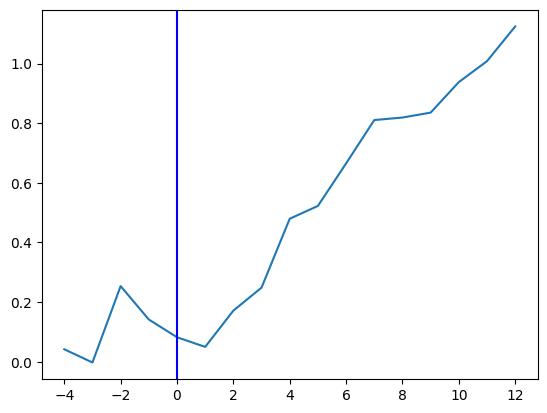

In [40]:
mean_list = [x / len(only_1997["stfips"].unique()) for x in mean_list]
# Plotting
# Treatment occurs at t = 1
x = np.arange(1992- g_d_1, 2009-g_d_1, 1) # I missed up length :/

plt.plot(x, mean_list)
# Computing the actual CI's/error bars -- the thing before was just the radius. 
#for i in range(len(mean_list)):
#    corresponding_year = i + 1992 - g_d_1
#    plt.errorbar(x=corresponding_year, y=mean_list[i], yerr=CI_list[i], \
#                 color="black", capsize=3, linestyle="None",\
#                marker="s", markersize=7, mfc="black", mec="black")

# Line which indicates after when treatment occurs. 
plt.axvline(x=0, color='b')

plt.show() 